In [16]:
#Import needed packages

import pandas as pd
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error,accuracy_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression



In [2]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [17]:
df= pd.read_csv('wine_enthusiast_dataset.csv')
df_remove_empty = df.dropna()#removes rows with empty data under any column
df_cleaned = df_remove_empty.drop_duplicates()#removes duplicate rows
df_cleaned.to_csv('cleaned_wine_data.csv', index=False)#save cleaned excel sheet

In [69]:
# Assume best wine has the highest points to price ratio 

# Creating copy of dataframe so pandas doesn't get confused as to whether the dataframe is being viewed or edited
df_cleaned_copy = df_cleaned.copy()  # Create a copy of the DataFrame

# Calculate 'points_per_price' and create a new column
df_cleaned_copy['points_per_price'] = df_cleaned_copy['points'].div(df_cleaned_copy['price'])

# Find the index of the row with the maximum 'points_per_price' value
max_index = df_cleaned_copy['points_per_price'].idxmax()

# Access the entire row with the maximum 'points_per_price' value
row_with_max_points_per_price = df_cleaned_copy.loc[max_index]

#pd.reset_option('display.max_colwidth')#shows formatted output
#pd.set_option('display.max_colwidth', None)# shows entire output

# Print the row
print(row_with_max_points_per_price)

wine_id                                                              59507
country                                                                 US
description              Sweet and fruity, this canned wine feels soft ...
designation                                                        Unoaked
points                                                                  83
price                                                                  4.0
province                                                        California
region_1                                                        California
region_2                                                  California Other
taster_name                                                     Jim Gordon
taster_twitter_handle                                     @gordone_cellars
title                      Pam's Cuties NV Unoaked Chardonnay (California)
variety                                                         Chardonnay
winery                   

In [7]:
#we assume best vineyard is one that has the most number of wines being produced in the top 10 wines wrt to points/price ratio
# Sort the DataFrame by 'points_per_price' in descending order
sorted_df = df_cleaned_copy.sort_values(by='points_per_price', ascending=False)

# consider top n amount of wines, for this example the top 10 wines are being considered 
n= 10
top_n_wines = sorted_df.head(n)
#cloning this list so it can be edited
cloned_df = top_n_wines.copy()

# New list of index values to be used for weighting, alternative method being resetting the index 
new_index_values = list(range(0, n))

# Replace the index of cloned_df with the new index values
cloned_df.index = new_index_values

# new column with weighted values for each winery
cloned_df['Weighted_Value'] = (n - cloned_df.index) / n

#sum of weighted values for each winery
result_desig = cloned_df.groupby('designation')['Weighted_Value'].sum().reset_index()
result_winery = cloned_df.groupby('winery')['Weighted_Value'].sum().reset_index()

#winery with the highest sum of weighted values
best_vineyard = result_desig[result_desig['Weighted_Value'] == result_desig['Weighted_Value'].max()]['designation'].values[0]
best_winery = result_winery[result_winery['Weighted_Value'] == result_winery['Weighted_Value'].max()]['winery'].values[0]

print(f'The vineyard for producing best wine is {best_vineyard} at the {best_winery} winery.')
#print(best_winery)

The vineyard for producing best wine is Organic Grapes at the Earth's Harvest winery.


The above code gives best vineyard using weighted positions of the point-to-price ratio which in itself is the weighted rating-to-cost for 'best' wine

In [72]:
#top 3 wines in sorted_df created in the last question
pd.set_option('display.max_colwidth', None)
top_3_wines = sorted_df.head(5)
print(f'Top 3 wines are given by {top_3_wines}')


Top 3 wines are given by         wine_id country  \
9166      59507      US   
85764    104412      US   
20976     37951      US   
8273       8428      US   
110829    63697      US   

                                                                                                                                                                                                                                         description  \
9166                                                                                Sweet and fruity, this canned wine feels soft and syrupy, with sugary pear as the primary flavor on the palate. It's a basic white wine in a convenient package.   
85764   This sparkling wine is the best of ManCan's three new canned offerings. It has plenty of rich fruit flavors and a buttery note. Lively bubbles settle into the smooth, creamy texture, leaving an overall impression of easygoing enjoyment.   
20976                                               This wine has a 

Which of the factors (price, country, variety, taster) are most important in determining the overall score of a wine?

implement feature correlation 
https://medium.com/@ManishChablani/measuring-feature-importance-removing-correlated-features-0aa4c856b200#:~:text=To%20get%20an%20overview%20of,has%20on%20the%20model%20output.

Feautures to be considered:
- Price
- Country
- Variety
- Taster


Since 3 of the 4 features are categorical, to analyse their impact on the price, they need to be converted to have a numerical form, mainly through one-hot encoding, binary encoding and label encoding

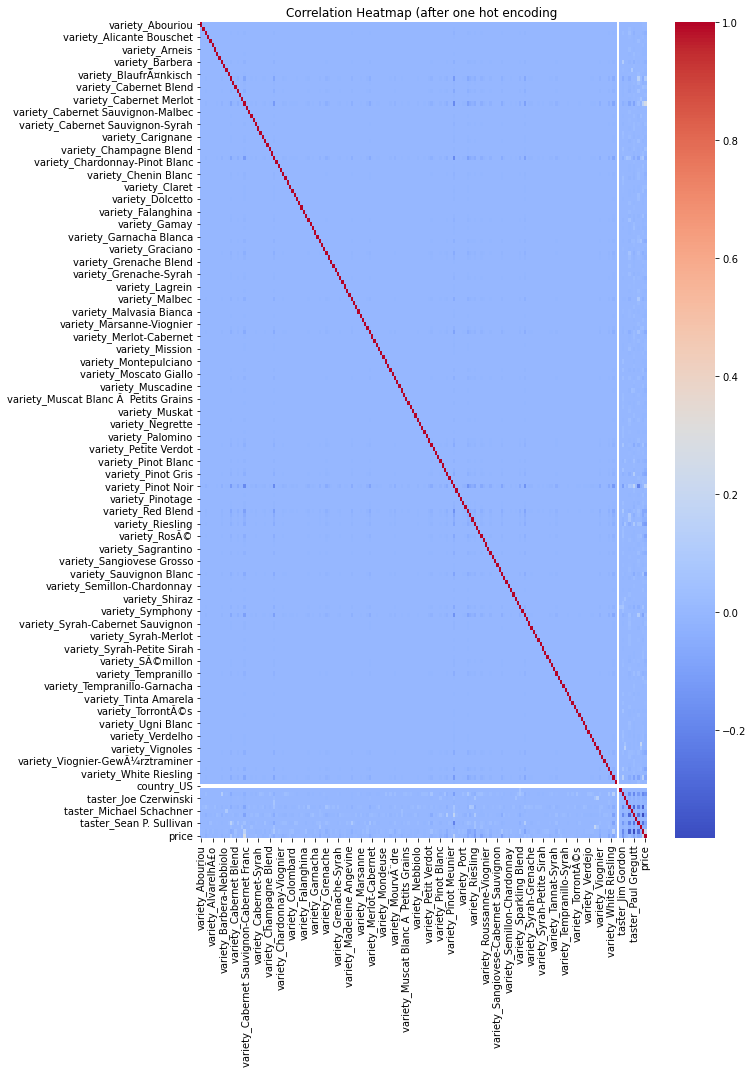

In [48]:
#question 3
# Perform one-hot encoding on 'variety', 'country', and 'taster' columns
one_hot_variety = pd.get_dummies(df_cleaned['variety'], prefix='variety')
one_hot_country = pd.get_dummies(df_cleaned['country'], prefix='country')
one_hot_taster = pd.get_dummies(df_cleaned['taster_name'], prefix='taster')

# Concatenate the one-hot encoded columns with the 'price' column
encoded_df = pd.concat([one_hot_variety, one_hot_country, one_hot_taster, df_cleaned['price']], axis=1)

# Calculate the correlation matrix
corr_matrix = encoded_df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 15)) 
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap (after one hot encoding ')
plt.show()

This is too complicated to extract any meaningful insights so binary encoding needs to be implemented as it reduces dimensionality.

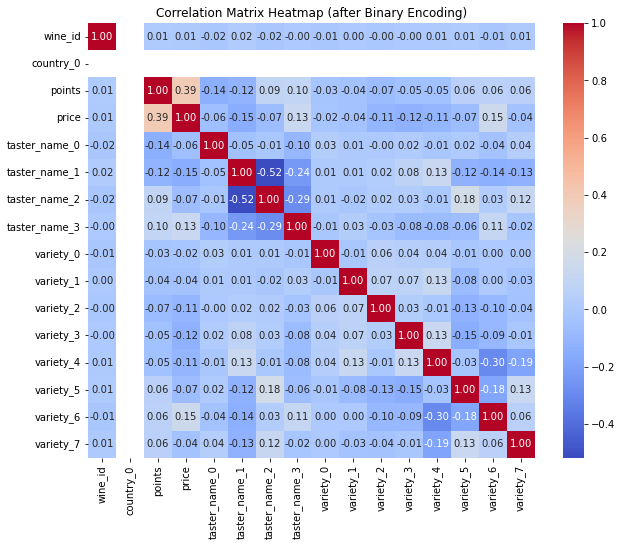

In [11]:
#binary encoding
bin_encoder = ce.BinaryEncoder(cols=['variety', 'taster_name', 'country'])
df1_bin_encoded = bin_encoder.fit_transform(df_cleaned)

#generating correlation matrix
correlation_matrix_binary = df1_bin_encoded.corr()

# Creating a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_binary, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap (after Binary Encoding)')
plt.show()

Binary encoding results in a fixed number of columns based on the number of categories to be encoded. Each binary column does not correspond to one specific category but rather a combination of categories. Therefore, it's not possible to name the columns after the specific categories they represent, as each category is represented by a combination of bits across multiple columns. The solution here would be to reduce dimensionality and consider correlation between catergories as a whole, which is possible with label encoding.

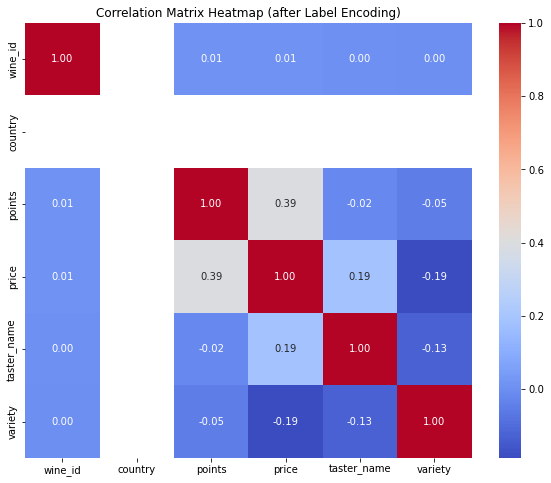

In [17]:
#label encoding
#creating instance of label encoder
label_encoder = LabelEncoder()

# Label encode the categorical columns
df1_labelencoded = df_cleaned.copy()
df1_labelencoded['variety'] = label_encoder.fit_transform(df1_labelencoded['variety'])
df1_labelencoded['taster_name'] = label_encoder.fit_transform(df1_labelencoded['taster_name'])
df1_labelencoded['country'] = label_encoder.fit_transform(df1_labelencoded['country'])

correlation_matrix_label = df1_labelencoded.corr()#correlation matrix

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_label, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap (after Label Encoding)')
plt.show()

Feature Importance:

Use techniques like feature importance ranking or feature selection methods (e.g., SelectKBest, Recursive Feature Elimination) to identify which features (price, country, taster) have the most significant impact on wine ratings.

Machine Learning Models:

Build predictive models to quantify the relationships between the features (price, country, taster) and wine ratings. You can use regression models, such as linear regression, decision trees, or random forests, to predict wine ratings based on these features.
Evaluate the model's performance using appropriate metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), or R-squared (R2

To analyse importance of each feature, we need to build a model which predicts points of a wine based on mentioned features. We will be using SVM due to relatively high accuracy compared to other classifiers. 

In [46]:
# Select the features and the label
X = df1_labelencoded[['price', 'taster_name', 'country','variety']]
y = df1_labelencoded['points']

# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)#


In [47]:
# Create and train the SVM model
svm_model = SVR(kernel='linear')  # You can use other kernels as well (e.g., 'rbf', 'poly')
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model by calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")



Mean Absolute Error (MAE): 1.9984124492243822


need sampled data to train model on to allow greater experimentation within a given timeframe

In [22]:
# RFE will take too long on full dataset so we need a smaller sample
# Randomly sample 20% of the data
sampled_data = df1_labelencoded.sample(frac=0.2, random_state=42)  

In [23]:
# Selecting the features and the label
X_s = sampled_data[['price', 'taster_name', 'country','variety']]
y_s = sampled_data['points']

# Split the dataset into training and testing sets(80-20 split)
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_s_train = scaler.fit_transform(X_s_train)
X_s_test = scaler.transform(X_s_test)

In [27]:
# Create and train the SVM model
svm_s_model = SVR(kernel='linear')  # You can use other kernels as well (e.g., 'rbf', 'poly')
svm_s_model.fit(X_s_train, y_s_train)

# Make predictions on the test set
y_s_pred = svm_s_model.predict(X_s_test)

# Evaluate the model by calculating Mean Absolute Error (MAE)
mae_s = mean_absolute_error(y_s_test, y_s_pred)
print(f"Mean Absolute Error (MAE): {mae_s}")


Mean Absolute Error (MAE): 2.0441889539432996


In [73]:

# Create RFE instance
rfe = RFE(estimator=svm_s_model, n_features_to_select=1)  # You can select the number of features you want

# Fit RFE model to the data
rfe.fit(X_s, y_s)

# Retrieve ranking of features (1 means selected, higher ranks are eliminated)
feature_ranking = rfe.ranking_



In [30]:
# Get the selected features
selected_features =  X.columns[rfe.support_]
# Print the selected features
print("Selected Features:", selected_features)

Selected Features: Index(['taster_name'], dtype='object')


In [35]:
#need to store ranking of features to analyse for importance
# Create a DataFrame to store feature rankings
feature_rankings_df = pd.DataFrame({'Feature': X.columns, 'Ranking': rfe.ranking_})

# Sort the features by their ranking (lower ranking means more important)
feature_rankings_df = feature_rankings_df.sort_values(by='Ranking')

# Print the hierarchy of features based on their rankings
print("Feature Hierarchy Based on Rankings:")
print(feature_rankings_df)

Feature Hierarchy Based on Rankings:
       Feature  Ranking
1  taster_name        1
0        price        2
3      variety        3
2      country        4


Since we were able to get rankings based on a sample of the total data, we can attempt to get rankings on a larger sample for greater accuracy

In [37]:
# Randomly sample 50% of the data
sampled_data2 = df1_labelencoded.sample(frac=0.5, random_state=42)  

In [38]:
# Select the features and the label
X_s2 = sampled_data2[['price', 'taster_name', 'country','variety']]
y_s2 = sampled_data2['points']

# Split the dataset into training and testing sets(80-20 split)
X_s2_train, X_s2_test, y_s2_train, y_s2_test = train_test_split(X_s2, y_s2, test_size=0.2, random_state=42)

# Standardize the features 
scaler2 = StandardScaler()
X_s2_train = scaler2.fit_transform(X_s2_train)
X_s2_test = scaler2.transform(X_s2_test)

In [39]:
# Create and train the SVM model
svm_s2_model = SVR(kernel='linear')  # You can use other kernels as well (e.g., 'rbf', 'poly')
svm_s2_model.fit(X_s2_train, y_s2_train)

# Make predictions on the test set
y_s2_pred = svm_s2_model.predict(X_s2_test)

# Evaluate the model by calculating Mean Absolute Error (MAE)
mae_s2 = mean_absolute_error(y_s2_test, y_s2_pred)
print(f"Mean Absolute Error (MAE): {mae_s2}")


Mean Absolute Error (MAE): 1.9586885164366323


In [40]:

# Create RFE instance
rfe2 = RFE(estimator=svm_s2_model, n_features_to_select=1)  # You can select the number of features you want

# Fit RFE model to the data
rfe2.fit(X_s2, y_s2)

# Retrieve ranking of features (1 means selected, higher ranks are eliminated)
feature_ranking2 = rfe2.ranking_


In [44]:
# Create DataFrame to store feature rankings
feature_rankings2_df = pd.DataFrame({'Feature': X.columns, 'Ranking': rfe2.ranking_})

# Sort the features by their ranking (lower ranking means more important)
feature_rankings2_df = feature_rankings2_df.sort_values(by='Ranking')

# Print the hierarchy of features based on their rankings
print("Feature Hierarchy Based on Rankings:")
print(feature_rankings2_df)

Feature Hierarchy Based on Rankings:
       Feature  Ranking
1  taster_name        1
0        price        2
3      variety        3
2      country        4


After having sampled both 20% and 50% of the data with same results, we can assume the the same rankings of features hold true for the entire dataset

Lastly, if I typically enjoy a wine which is “dry” and has “citrus” flavours, which variety of wine should I try?

In [6]:
#question 4
description_column = df_cleaned['description']

# Create a new column 'has_dry_and_citrus' that checks if both 'dry' and 'citrus' are mentioned
df_cleaned['has_dry_and_citrus'] = description_column.apply(lambda x: 'dry' in x.lower() and 'citrus' in x.lower())

# Create a new DataFrame containing only the wines that have both 'dry' and 'citrus'
filtered_wines = df_cleaned[df_cleaned['has_dry_and_citrus']]

# Reset the index of the filtered DataFrame
filtered_wines.reset_index(drop=True, inplace=True)

# Calculate the point per price value and store it in a new column 'point_per_price'
filtered_wines.loc[:, 'point_per_price'] = filtered_wines['points'] / filtered_wines['price']


# Create a new DataFrame with the columns you need
ranked_wines = filtered_wines.copy()

# Calculate the point per price value and store it in a new column 'point_per_price'
ranked_wines['point_per_price'] = ranked_wines['points'] / ranked_wines['price']

# Sort the DataFrame by 'point_per_price' in descending order to rank the wines
ranked_wines = ranked_wines.sort_values(by='point_per_price', ascending=False)

# Reset the index for the ranked DataFrame
ranked_wines.reset_index(drop=True, inplace=True)

# Display the ranked DataFrame
print(ranked_wines)

     wine_id country                                        description  \
0      72670      US  This light-bodied wine brings enjoyment at a v...   
1      11809      US  This light-bodied wine brings enjoyment at a v...   
2     101353      US  Labeled late harvest, but not terribly sweet, ...   
3     115481      US  Off-dry with lemon-drop fruit flavors, a lick ...   
4      69544      US  This is fresh and citrusy, with lemon and grap...   
..       ...     ...                                                ...   
181    99110      US  Made in a mÃ©thode Champenoise style, this is ...   
182   109332      US  Seductively smooth and intriguingly aromatic, ...   
183    79075      US  A bright golden color and generous, intricate ...   
184    58749      US  Complex and well balanced, this elegant dry, b...   
185    93108      US  Leather pouch and earthy cedar and forest floo...   

                 designation  points  price    province              region_1  \
0             Will

C:\Users\hskin\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [15]:
# consider top n amount of wines, for this example the top 10 wines are being considered 
m= 10

# Select the top m rows from the DataFrame
top_ranked_wines = ranked_wines.head(m)

# Calculate the weighted values for each winery based on their ranking
top_ranked_wines['Weighted_Value'] = top_ranked_wines.index.map(lambda index: (m - index) / m)

# Sum of weighted values for each winery
top_ranked_wines_weighted = top_ranked_wines.groupby('variety')['Weighted_Value'].sum().reset_index()

# Winery with the highest sum of weighted values
best_variety = top_ranked_wines_weighted.loc[top_ranked_wines_weighted['Weighted_Value'].idxmax()]['variety']

print(f'The best variety for dry and citrus-flavored wine is {best_variety}.')

The best variety for dry and citrus-flavored wine is Pinot Grigio.


C:\Users\hskin\AppData\Local\Temp/ipykernel_18732/2294986150.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ranked_wines['Weighted_Value'] = top_ranked_wines.index.map(lambda index: (m - index) / m)
